In [18]:
import torchvision
import torch
from torchvision import transforms


In [4]:
model = torchvision.models.segmentation.deeplabv3_resnet101(num_classes=2)


In [25]:

"""model.eval()
img = torch.tensor(valid_images[0],
                         dtype=torch.float32).permute(2,1,0).unsqueeze(0)
print(img.shape)
mask = model(img)"""

torch.Size([1, 3, 256, 256])


In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
from torchvision import transforms, models
from PIL import Image

# Define paths for training, validation, and test datasets
train_images_path = r"/home/bhatti/fyp1/resized images and masks-20240708T073058Z-001/resized images and masks/train/resized images"
train_masks_path = r"/home/bhatti/fyp1/resized images and masks-20240708T073058Z-001/resized images and masks/train/resized masks"
valid_images_path = r"/home/bhatti/fyp1/resized images and masks-20240708T073058Z-001/resized images and masks/valid/resized images"
valid_masks_path = r"/home/bhatti/fyp1/resized images and masks-20240708T073058Z-001/resized images and masks/valid/resized masks"
test_images_path = r"/home/bhatti/fyp1/resized images and masks-20240708T073058Z-001/resized images and masks/test/resized images"
test_masks_path = r"/home/bhatti/fyp1/resized images and masks-20240708T073058Z-001/resized images and masks/test/resized masks"

# Get lists of images and masks files for training
train_images_files = sorted(os.listdir(train_images_path))
train_masks_files = sorted(os.listdir(train_masks_path))

# Get lists of images and masks files for validation
valid_images_files = sorted(os.listdir(valid_images_path))
valid_masks_files = sorted(os.listdir(valid_masks_path))

# Get list of images files for test
test_images_files = sorted(os.listdir(test_images_path))
test_masks_files = sorted(os.listdir(test_masks_path))

# Define a function to load images and masks as numpy arrays using cv2
def load_image_and_mask(image_file, mask_file, images_path, masks_path):
    image = cv2.imread(os.path.join(images_path, image_file))
    mask = cv2.imread(os.path.join(masks_path, mask_file), cv2.IMREAD_GRAYSCALE)
    return image, mask

# Load images and masks for training
train_images, train_masks = [], []
for image_file, mask_file in zip(train_images_files, train_masks_files):
    img, msk = load_image_and_mask(image_file, mask_file, train_images_path, train_masks_path)
    train_images.append(img)
    train_masks.append(msk)

# Convert lists to numpy arrays for training
train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Load images and masks for validation
valid_images, valid_masks = [], []
for image_file, mask_file in zip(valid_images_files, valid_masks_files):
    img, msk = load_image_and_mask(image_file, mask_file, valid_images_path, valid_masks_path)
    valid_images.append(img)
    valid_masks.append(msk)

# Convert lists to numpy arrays for validation
valid_images = np.array(valid_images)
valid_masks = np.array(valid_masks)

# Load images and masks for test
test_images, test_masks = [], []
for image_file, mask_file in zip(test_images_files, test_masks_files):
    img, msk = load_image_and_mask(image_file, mask_file, test_images_path, test_masks_path)
    test_images.append(img)
    test_masks.append(msk)

# Convert lists to numpy arrays for test
test_images = np.array(test_images)
test_masks = np.array(test_masks)

# Print the shapes of images and masks arrays for training, validation, and test datasets
print(f"Training Images shape: {train_images.shape}")
print(f"Training Masks shape: {train_masks.shape}")
print(f"Validation Images shape: {valid_images.shape}")
print(f"Validation Masks shape: {valid_masks.shape}")
print(f"Test Images shape: {test_images.shape}")
print(f"Test Masks shape: {test_masks.shape}")

Training Images shape: (4776, 256, 256, 3)
Training Masks shape: (4776, 256, 256)
Validation Images shape: (243, 256, 256, 3)
Validation Masks shape: (243, 256, 256)
Test Images shape: (167, 256, 256, 3)
Test Masks shape: (167, 256, 256)


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import numpy as np
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Custom dataset
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks / 255
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            image = self.transform(image)

        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask

# Data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and dataloaders
train_dataset = SegmentationDataset(train_images, train_masks, transform=transform)
valid_dataset = SegmentationDataset(valid_images, valid_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# Load model
model = models.segmentation.deeplabv3_resnet101(num_classes=2)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 25
best_iou = 0.0
"""
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    with tqdm(train_loader, unit="batch") as tepoch:
        for images, masks in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            tepoch.set_postfix(loss=running_loss / len(train_loader))

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        with tqdm(valid_loader, unit="batch") as vepoch:
            for images, masks in vepoch:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)['out']
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += masks.numel()
                correct += (predicted == masks).sum().item()

    val_loss /= len(valid_loader)
    accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Save the best model
    if accuracy > best_iou:
        best_iou = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved!")

print("Training complete.")
"""

'\nfor epoch in range(num_epochs):\n    model.train()\n    running_loss = 0.0\n\n    with tqdm(train_loader, unit="batch") as tepoch:\n        for images, masks in tepoch:\n            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")\n\n            images = images.to(device)\n            masks = masks.to(device)\n\n            optimizer.zero_grad()\n            outputs = model(images)[\'out\']\n            loss = criterion(outputs, masks)\n            loss.backward()\n            optimizer.step()\n\n            running_loss += loss.item()\n            tepoch.set_postfix(loss=running_loss / len(train_loader))\n\n    epoch_loss = running_loss / len(train_loader)\n    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")\n\n    # Validation loop\n    model.eval()\n    val_loss = 0.0\n    correct = 0\n    total = 0\n\n    with torch.no_grad():\n        with tqdm(valid_loader, unit="batch") as vepoch:\n            for images, masks in vepoch:\n                images = images

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load model
model = models.segmentation.deeplabv3_resnet101(num_classes=2)
model.load_state_dict(torch.load('best_model.pth'))  # Load your best model weights
model = model.to(device)
model.eval()

# Loss function (if needed during testing)
criterion = nn.CrossEntropyLoss()

# Test loop
test_loss = 0.0
test_correct = 0
test_total = 0
test_dataset = SegmentationDataset(test_images, test_masks, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
with torch.no_grad():
    with tqdm(test_loader, unit="batch") as tepoch:
        for images, masks in tepoch:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            test_total += masks.numel()
            test_correct += (predicted == masks).sum().item()

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Additional evaluation metrics or visualization if needed


100%|██████████| 21/21 [00:03<00:00,  6.13batch/s]

Test Loss: 0.4043, Accuracy: 0.8744


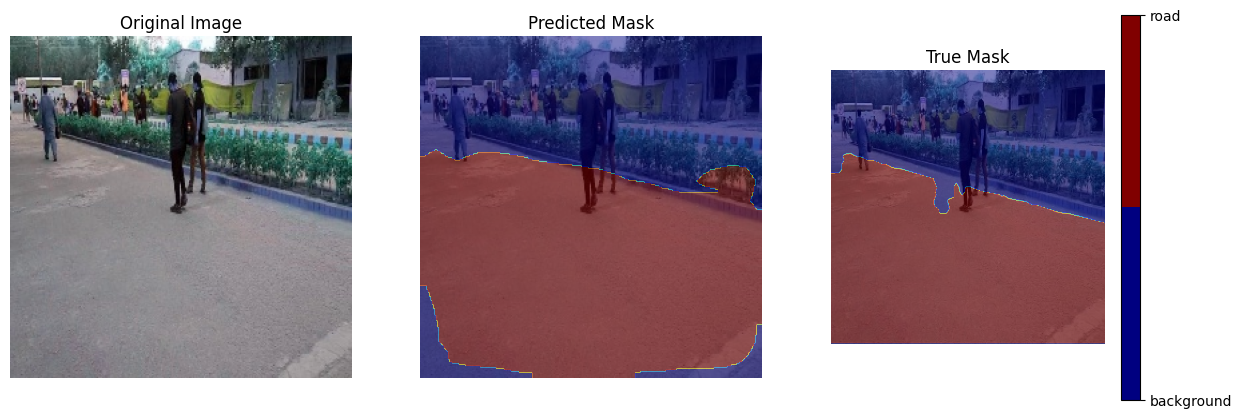

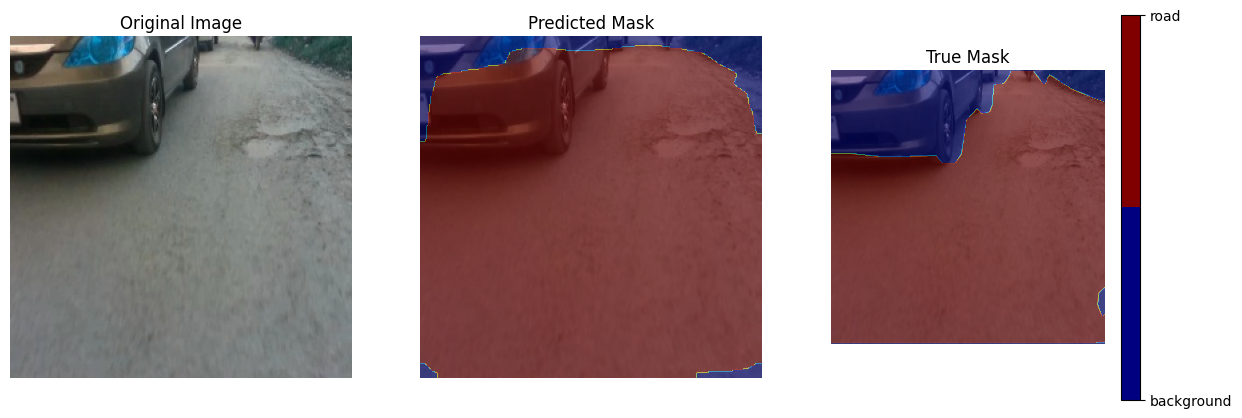

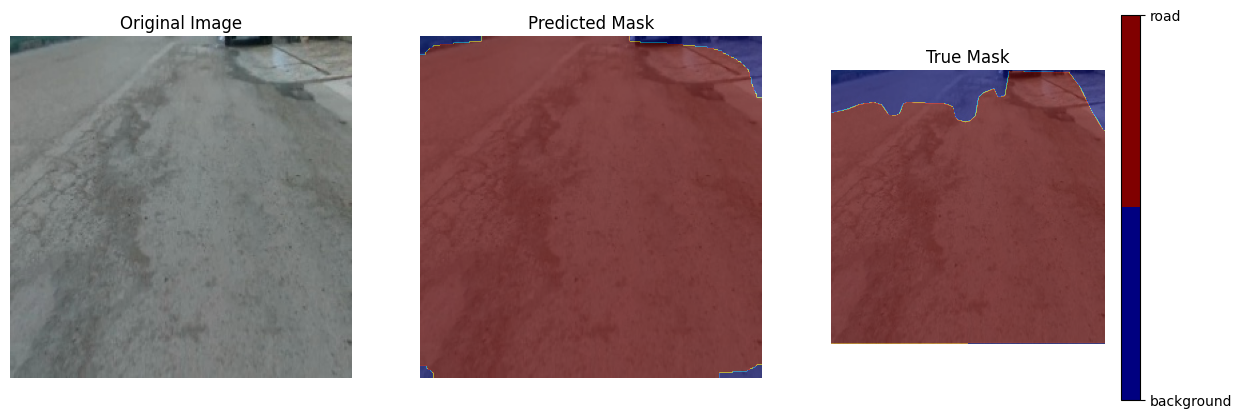

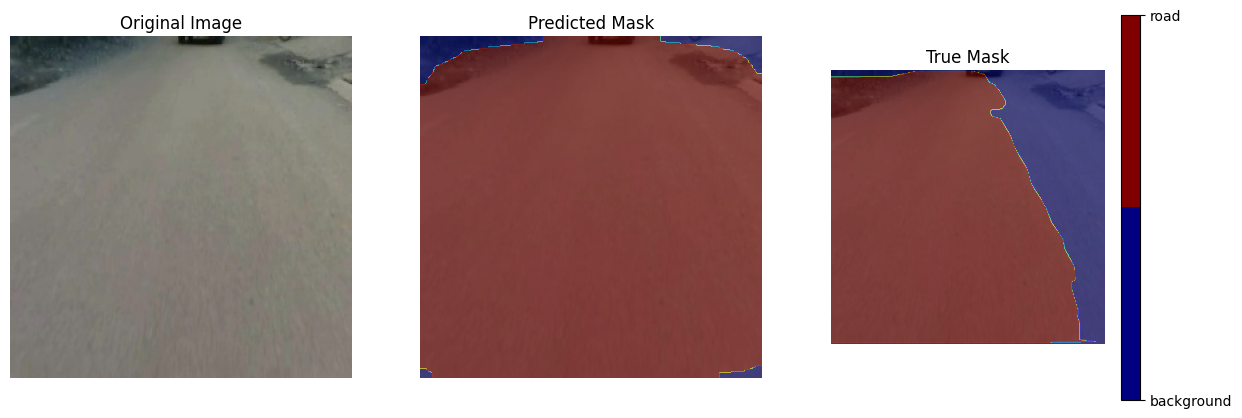

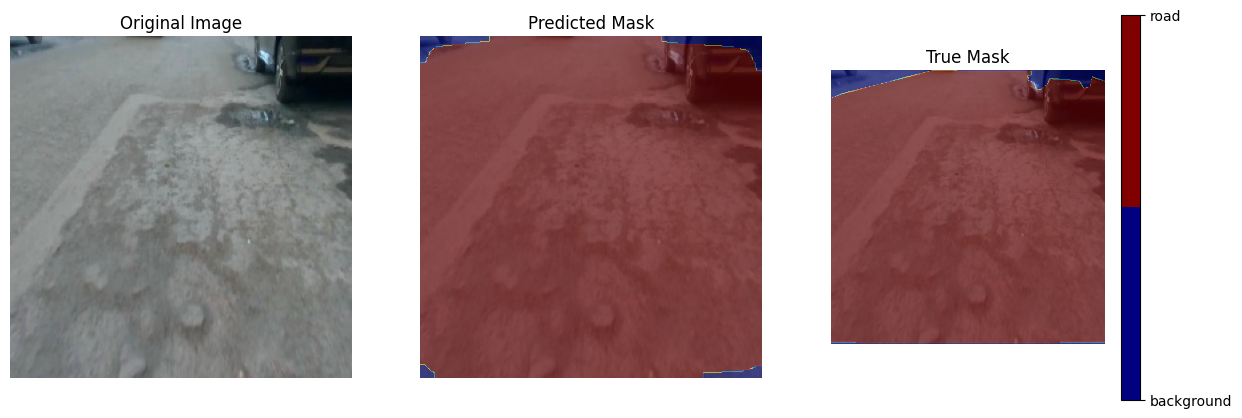

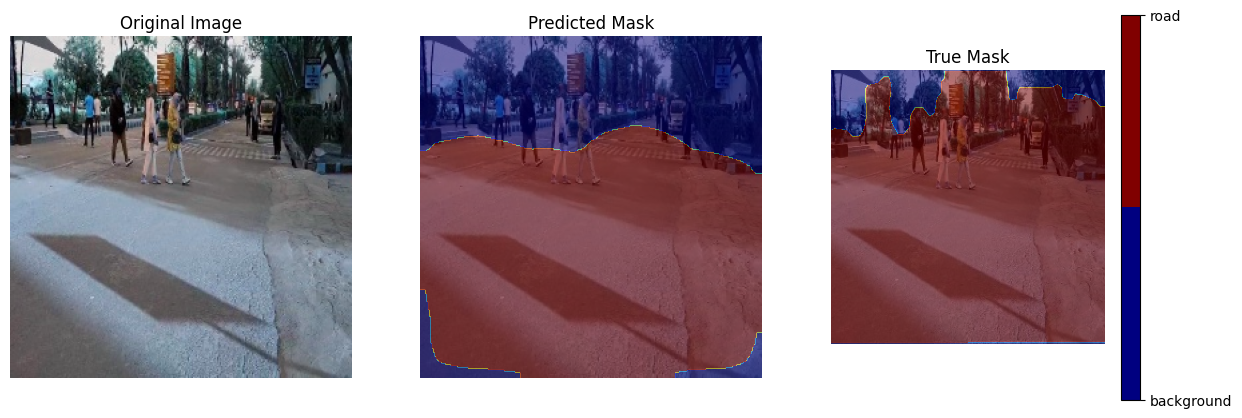

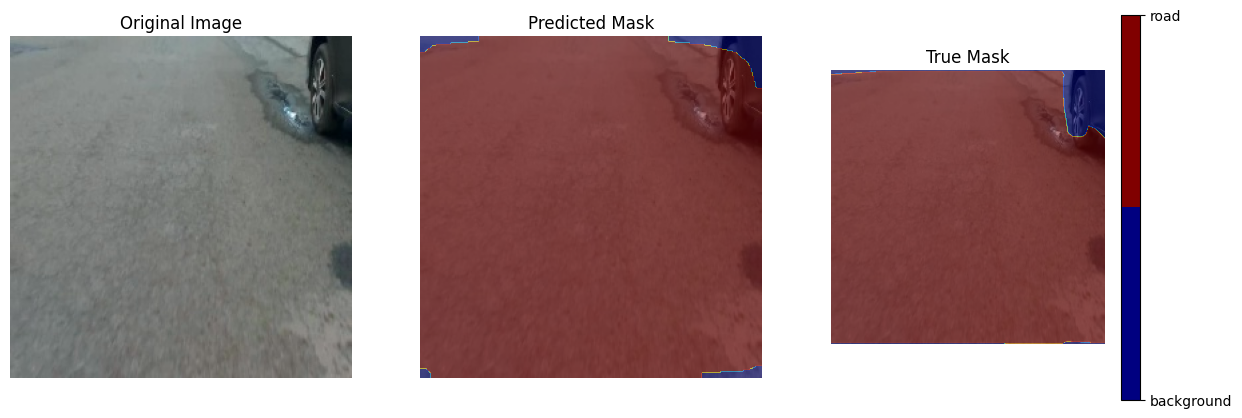

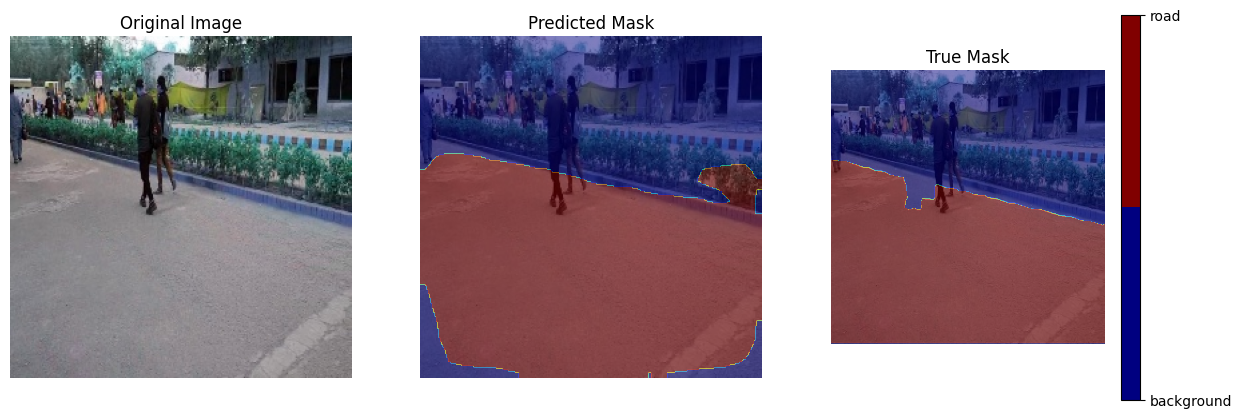

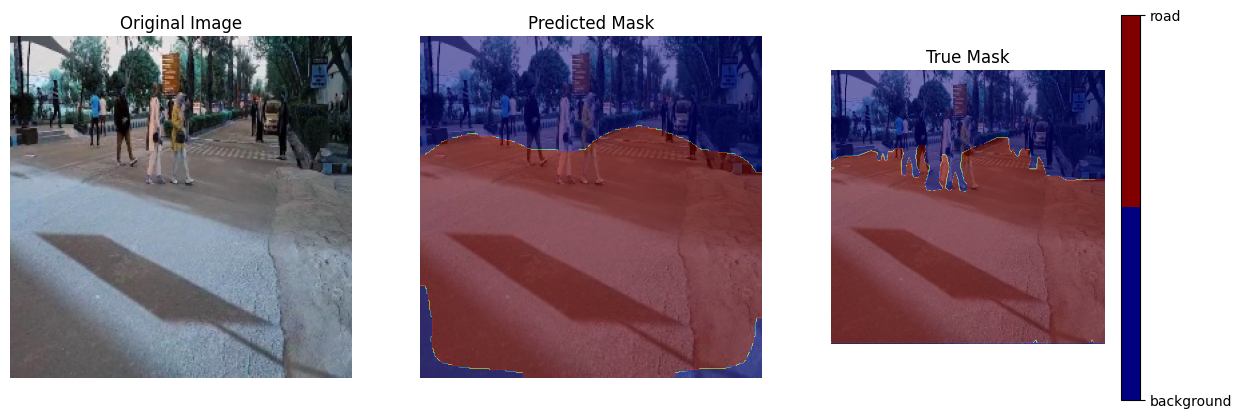

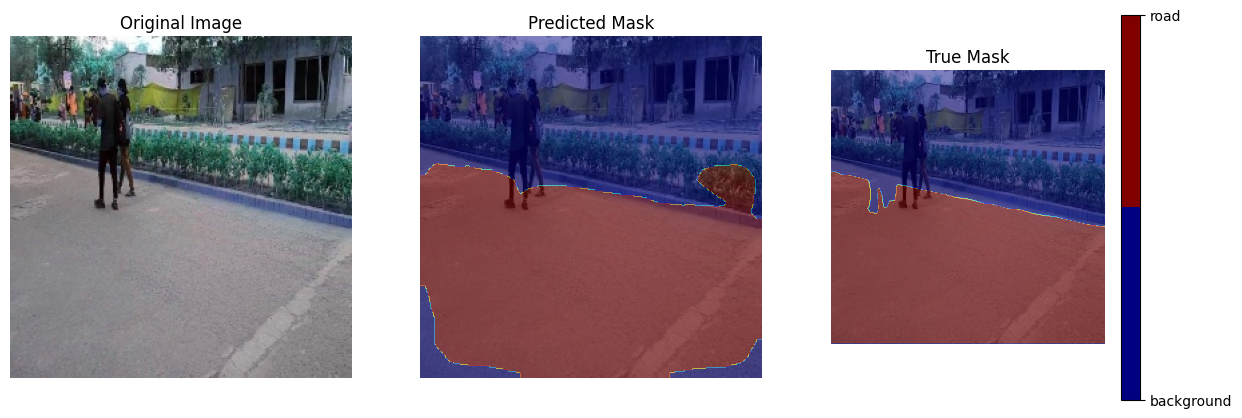

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
from torchvision import transforms, models
from PIL import Image

# Function to preprocess the output tensor from the model
def preprocess_output(output):
    output = output['out'][0]  # Take the first batch element
    output = torch.argmax(output, dim=0)  # Get the class with the highest score
    return output.cpu().numpy()

# Function to visualize the original image and its segmentation mask
def visualize_segmentation(image, pred_mask, true_mask, class_labels, alpha=0.5):
    plt.figure(figsize=(15, 5))

    # Display the original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Display the predicted segmentation mask
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(pred_mask, cmap='jet', alpha=alpha)  # Overlay predicted mask with transparency
    plt.title("Predicted Mask")
    plt.axis('off')

    # Display the true segmentation mask
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(true_mask, cmap='jet', alpha=alpha)  # Overlay true mask with transparency
    plt.title("True Mask")
    plt.axis('off')

    # Create a colormap and a normalizer for the legend
    cmap = plt.get_cmap('jet', len(class_labels))
    norm = mcolors.Normalize(vmin=0, vmax=len(class_labels)-1)

    # Create the colorbar
    cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca())
    cbar.set_ticks(np.arange(len(class_labels)))
    cbar.set_ticklabels(class_labels)

    plt.show()

if __name__ == "__main__":
    # Load your trained DeepLabV3 model
    model = models.segmentation.deeplabv3_resnet101(num_classes=2)
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    # Load and preprocess your validation images and masks
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Assuming valid_images and valid_masks are your validation dataset
    num_samples = len(test_images)
    random_indices = np.random.choice(num_samples, size=10, replace=False)

    for idx in random_indices:
        input_tensor = preprocess(test_images[idx]).unsqueeze(0)  # Add batch dimension

        # Make a prediction
        with torch.no_grad():
            output = model(input_tensor)

        # Preprocess the output to get the segmentation mask
        pred_mask = preprocess_output(output)

        # Convert the original image and true mask to formats suitable for display
        input_image = np.array(test_images[idx])
        true_mask = np.array(test_masks[idx])  # Assuming valid_masks contains the ground truth masks

        # Define the class labels (adjust these according to your dataset)
        class_labels = ["background", "road"]  # Example class labels

        # Visualize the original image, predicted mask, and true mask with legend
        visualize_segmentation(input_image, pred_mask, true_mask, class_labels)
